# MSE 446 Project Report
Group 19  
Lucy He, Junshi Li, Jason Liu, Carrick Shi


## Introduction and Problem Statement
Wildfires have significant impacts on social structures, such as disrupting wildlife activities, and posing substantial economic challenges to cities. Recent catastrophic wildfires highlight the growing threat of these natural disasters. In January 2025, Los Angeles faced unprecedented winter wildfires, causing 29 fatalities and destroying over 16,000 structures [1]. In 2023, Alberta had 36 severe fires burning 2.2 million hectares—far exceeding the five-year average of 169,556 hectares [2]. These events emphasize the urgent need for developing an accurate and effective wildfire prediction model to facilitate early intervention and mitigate future risks.

Multiple ongoing research in Machine Learning (ML) have made notable contributions in the area of wildfire prediction. For example, Sanabria et al. [3] calculated the spatial distribution of Fire Weather Indices across Australia based on ML techniques, demonstrating how ML can be used to improve the understanding of wildfire risks through historical weather conditions. In [4], Shadrin et al. employed a neural network based on the MA-Net architecture to predict the spreading of wildfires up to five days in advance. Similar to our study, Bayat and Yıldız [5] evaluated multiple models for estimating fire size, including Multilayer Perceptron (MLP), Linear Regression, Support Vector Machine (SVM), K-Nearest Neighbors (KNN), Decision Tree, and Stacking methods. Among these, the SVM model performed best, achieving a Mean Absolute Error (MAE) of 12.89, while the MLP model showed the lowest accuracy with an MAE of 38.75. These studies highlight the usefulness of weather data and machine learning to accurately predicting wildfire risk, spread, and size.

The goal of this project is to predict wildfire occurrence probabilities based on geospatial data such as weather, lightning occurrences and population density. According to Natural Resources Canada [6], Alberta has the highest Fire Weather Index (FWI) values in Canada due to frequent summer wildfires, large forested areas, and dry climate conditions. Given Alberta's high fire activity, we will focus our wildfire prediction problem on this region to develop targeted mitigation strategies. In this project, we will compare three Machine Learning models: Logistic Regression, Decision Tree, and Fully Connected Neural Network, to determine which provides the most accurate predictions. Using k-fold cross-validation, these models will be evaluated based on a fraction of correct predictions and root mean square (RMS) error metrics to assess their effectiveness for wildfire forecasting.


## Data Sources and Preprocessing
To predict the probability of wildfire occurrence in any given location in Alberta for a given day, we combine datasets covering meteorological, environmental, and geospatial factors known to influence wildfire
activity. These features are from various sources, such as government databases and weather stations, to ensure a
comprehensive coverage of wildfire risk indicators.

Specifically, our datasets include information on historical wildfire records, meteorological weather data, lightning activity, and population density. Each dataset reveals different perspectives on the potential drivers of wildfire occurrence and spread, allowing us to construct a complete feature set that encompasses both fire and non-fire scenarios. This section details the selection and usage of the four data sources we use and describes the methods and strategies we employ for data enhancement and integration.

### Fire Data
The main data source for this project is the historical wildfire data from the Government of Alberta [7], which is publicly available through Alberta Open Data. This dataset contains over 26000 records of wildfires between 2006 and 2024, each entry includes the wildfire’s time of occurrence, geographic location in terms of latitude and longitude, and additional metadata such as the cause of fire, fuel type (vegetation classification in the area), and local weather conditions at the time of fire. This dataset serves as the foundation for our classification task, where we aim to predict the likelihood of wildfire occurrence based on environmental features.

However, having only records of wildfire occurrences is not sufficient for building a reliable classification model to predict whether a wildfire will occur. To effectively train a model to distinguish between fire and no-fire conditions, it is equally important to include data from periods and locations where no wildfires were reported.

To incorporate negative (non-fire) examples for training our model, we use the latitude and longitude coordinates from the wildfire dataset as reference points. We round these coordinates to one decimal place and group fires that occurred within the same rounded location. For each grouped location, we randomly generate additional timestamps spanning 2006 to 2024 that are not associated with recorded wildfires, such that in total, each location will have at least 10 entries of fire and non-fire date times, and these synthesized entries represent non-fire conditions. These synthesized entries represent non-fire conditions, which are essential for the model to learn the full decision boundary and avoid biased predictions.

From the historical wildfire dataset, we do not use the weather data provided as it lacks coverage for non-fire events and may introduce inconsistency. Instead, we source weather information separately to maintain uniformity across both fire and non-fire instances (see Weather Data section below). However, we can extract the Fire Behavior Prediction (FBP) System Fuel Types information from the wildfire data as a feature, since it can be assumed to remain relatively constant over the study period. A legend of the fuel type codes and their distribution across Canada can be found in the figure below [7]. Under the assumption that each location’s fuel type does not change over time, we can assign the same fuel types recorded in historical wildfires to the generated non-fire data entries. These new data entries will be uniquely identified by their longitude, latitude, and timestamp. Finally, we define a binary classifier label indicating fire occurrence (Fire = True/False), which serves as the target variable for training and evaluating our machine learning models.


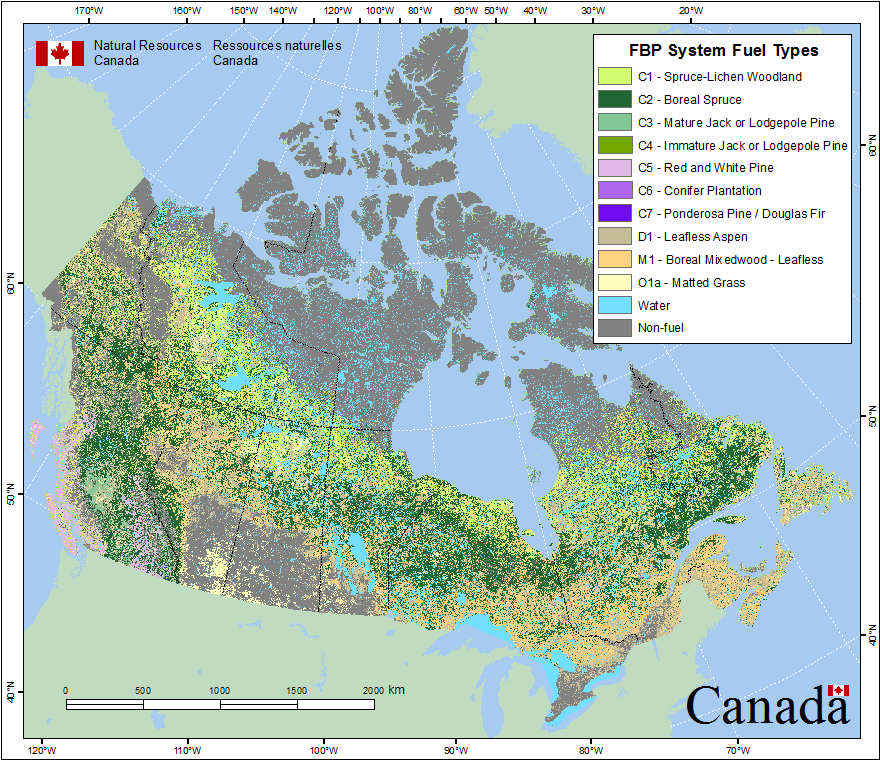
[8]

#### 1. Read wildfire data and filter for 2024
After filtering for non-empty data, there are 18931 historical wildfire entries.

In [1]:
import pandas as pd
import numpy as np

wildfire_file = "./data_processing/WildFireData/fp-historical-wildfire-data-2006-2024.csv"
wildfire_df = pd.read_csv(wildfire_file)
wildfire_df = wildfire_df[['YEAR','LATITUDE','LONGITUDE','GENERAL_CAUSE', 'FIRE_START_DATE', 'FUEL_TYPE']]
wildfire_df = wildfire_df.rename(columns={'FIRE_START_DATE': 'START_DATE'})
wildfire_df = wildfire_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'START_DATE'])
wildfire_df = wildfire_df.dropna(subset=['FUEL_TYPE'])
wildfire_df.to_csv('./data_processing/WildFireData/wildfire_alltime.csv', index=False)
display(wildfire_df.head(1))
print(f"Number of wildfires in Alberta 2006-2024: {len(wildfire_df)}")

wildfire2024_df = wildfire_df[wildfire_df['YEAR'] == 2024]
wildfire2024_df = wildfire2024_df.reset_index(drop=True)    # reset index
wildfire2024_df.to_csv('./data_processing/WildFireData/wildfire2024.csv', index=False)
display(wildfire2024_df.head(1))
print(f"Number of wildfires in Alberta 2024: {len(wildfire2024_df)}")

FileNotFoundError: [Errno 2] No such file or directory: './data_processing/WildFireData/fp-historical-wildfire-data-2006-2024.csv'

#### 2. Generate no-fire times for the same locations in 2024

##### 2.1 Function for Randomly Generating Time

In [ ]:
import bisect
from datetime import timedelta

def generate_random_times(n, existing_times, start_time, total_seconds):
    existing_times = sorted(existing_times)
    generated = []

    # Convert to list of timestamps in seconds since epoch for fast math
    existing_seconds = [pd.to_datetime(t).timestamp() for t in existing_times]
    generated_seconds = []

    attempts = 0
    max_attempts = 5000
    min_separation = 86400  # 24 hours in seconds

    while len(generated_seconds) < n and attempts < max_attempts:
        candidate = start_time + timedelta(seconds=np.random.randint(0, total_seconds))
        candidate_sec = candidate.timestamp()

        # Use bisect to insert into sorted list
        all_times = sorted(existing_seconds + generated_seconds)
        idx = bisect.bisect_left(all_times, candidate_sec)

        too_close = False
        if idx > 0 and abs(candidate_sec - all_times[idx - 1]) < min_separation:
            too_close = True
        elif idx < len(all_times) and abs(candidate_sec - all_times[idx % len(all_times)]) < min_separation:
            too_close = True

        if not too_close:
            generated.append(candidate)
            generated_seconds.append(candidate_sec)

        attempts += 1

    if len(generated_seconds) < n:
        print(f"Warning: Only generated {len(generated_seconds)} out of {n} due to 24-hour proximity rule.")

    return generated

##### 2.2 Generate Time and Location for No Fire Entries
To guarantee we have information of the vegetation fuel type information that we will use as a feature, we can only use the locations recorded in the wildfire dataset. Here we assume that the vegetation fuel type of the location does not change over time.

In [ ]:
def get_wildfire_df(in_file, out_file, start_time="2006-01-01", end_time="2024-12-31", new_generate=False):
    if new_generate:
        # Generate new data
        new_rows = []
        wildfire_df = pd.read_csv(in_file)
        wildfire_df[['LATITUDE_round', 'LONGITUDE_round']] = wildfire2024_df[['LATITUDE', 'LONGITUDE']].round(1)
        for (lat, lon), time_df in wildfire_df.groupby(['LATITUDE_round', 'LONGITUDE_round']):
            count = len(time_df)
            # make sure each location has at least 50 entries
            if count >= 50:
                num_to_generate = 1
            else:
                num_to_generate = 50 - count
            
            # Time range
            total_seconds = int((end_time - start_time).total_seconds())

            new_times = generate_random_times(num_to_generate, time_df['START_DATE'].tolist(), start_time, total_seconds)
            for t in new_times:
                # append latitude and longitude of the original entry
                new_rows.append({
                    'LATITUDE': time_df['LATITUDE'].values[0],
                    'LONGITUDE': time_df['LONGITUDE'].values[0],
                    'START_DATE': t,
                    'FUEL_TYPE': time_df['FUEL_TYPE'].values[0]
                })

        # Create DataFrame of new entries
        df_new = pd.DataFrame(new_rows)
        df_new['FIRE'] = False

        # Take only the date time and fuel information from the original data
        fire_loc_time_df = wildfire_df[['LATITUDE', 'LONGITUDE', 'START_DATE', 'FUEL_TYPE']]
        fire_loc_time_df['FIRE'] = True

        # Combine with original data
        all_loc_time_df = pd.concat([fire_loc_time_df, df_new], ignore_index=True)
        all_loc_time_df.to_csv(out_file, index=False)

    else:
        # Load existing data
        wildfire_df = pd.read_csv(in_file)
        all_loc_time_df = pd.read_csv(out_file)
    
    display(wildfire_df.head(1))
    display(all_loc_time_df)

    return all_loc_time_df

- All Time

In [ ]:
fire_nonfire_df = get_wildfire_df(in_file='./data_processing/WildFireData/wildfire_alltime.csv',
                                  out_file='./data_processing/WildFireData/wildfire&nonfire_alltime.csv', 
                                  new_generate=False)

,YEAR,LATITUDE,LONGITUDE,GENERAL_CAUSE,START_DATE,FUEL_TYPE
0,2006,56.249956,-117.18196,Resident,2006-04-02 12:00:00,O1a


,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE
0,56.249956,-117.181960,2006-04-02 12:00:00,O1a,True
1,53.606367,-115.915733,2006-04-03 12:10:00,O1a,True
2,53.610933,-115.594267,2006-04-03 12:15:00,O1a,True
3,53.608867,-115.609467,2006-04-03 12:10:00,O1b,True
4,51.152933,-115.034600,2006-04-02 14:25:00,O1b,True
...,...,...,...,...,...
203172,56.332733,-110.975833,2022-05-03 10:34:21,C2,False
203173,56.332733,-110.975833,2018-06-03 00:33:55,C2,False
203174,56.332733,-110.975833,2007-07-09 04:39:31,C2,False
203175,56.332733,-110.975833,2015-07-25 02:13:05,C2,False


- 2024

In [ ]:
fire_nonfire_df = get_wildfire_df(in_file='./data_processing/WildFireData/wildfire2024.csv',
                                  out_file='./data_processing/WildFireData/wildfire&nonfire2024.csv', 
                                  start_time="2024-01-01",
                                  new_generate=False)

,YEAR,LATITUDE,LONGITUDE,GENERAL_CAUSE,START_DATE,FUEL_TYPE
0,2024,55.199417,-112.400533,Agriculture Industry,2024-04-23 15:36:00,O1a


,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True
1,56.766883,-111.724250,2024-05-10 19:00:00,S1,True
2,51.961340,-115.340712,2024-05-20 15:33:00,C1,True
3,58.712345,-111.188683,2024-05-23 16:00:00,M2,True
4,55.645667,-116.067867,2024-05-24 11:10:00,O1a,True
...,...,...,...,...,...
7306,59.979362,-111.832023,2024-10-17 21:24:17,M2,False
7307,59.979362,-111.832023,2024-07-01 12:45:19,M2,False
7308,59.979362,-111.832023,2024-03-21 06:31:49,M2,False
7309,59.979362,-111.832023,2024-06-10 03:03:54,M2,False


### Weather Data: Temperature, Humidity, Wind, Rainfall
To obtain consistent and detailed weather information for both wildfire and non-wildfire events, we use two different sources of weather data: Alberta Weather Stations and OpenWeather API. The two weather data sources each offer distinct advantages and limitations, leading to a trade-off between spatial accuracy and temporal coverage.

The OpenWeather API provides highly localized and consistent weather data for both fire and non-fire cases; however, it is limited to the year 2024. This constraint reduces the size and diversity of our training dataset, as relying on data from a single year may introduce bias due to unique weather patterns.

In contrast, data from the Government of Alberta’s weather station spans a much longer period (2006–2024), allowing us to build a larger and more temporally diverse dataset. However, this way we would need to sacrifice spatial resolution, as it only records weather at fixed station locations. Based on a histogram of nearest-station distances, we selected a 50 km maximum distance threshold to limit location mismatch, but it still introduces an unavoidable approximation. Another limiting factor of using this dataset is that there are missing values and important weather parameters in weather stations, which affect the overall data quality.

#### Alberta Weather Stations
Our first main weather sources is the historical weather data from Environment and Climate Change Canada, available through the Government of Canada’s historical climate data portal. The dataset archives 600 weather stations located all across Alberta, where we extracted daily weather data from each station between 2006-2024. Inside the dataset, there are a total of 31 weather parameters, but we are only interested in some of the important ones which we believe are closely related to wildfires: 
- Max/Min/Mean Temperature (°C): High temperatures dry out vegetation, increasing flammability.
- Total Precip (mm): Low rainfall increases the dryness of plants, which also increases fire probability
- Speed of Max Gust (km/h, 10s deg): Strong winds accelerate fire spread
- Spatial feature (Longitude, Latitude): Some regions are more fire-prone due to different topography at different locations (ex., wildfires are less likely to occur in places with less vegetation)

Due to inconsistencies in data availability, such as missing weather conditions in some of the stations from 2006-2024, we need to filter the dataset to extract usable entries. For each fire and non-fire entry in the dataset, we map the location and timestamp to the nearest available weather station by first rounding the timestamp in the wildfire dataset to the nearest day. From the subset of stations that contain valid data for that day, we identify the closest station geographically to provide the associated weather data. After filtering, we obtain 106085 data points in total, of which 9599 correspond to true wildfire events. 

*Pre-processing of this data involves checking data availability and feature selection, which is recorded in the Weather Station Data Preprocessing section below

#### Open Weather API
We also used another source of weather data: OpenWeather API. This API allows us to retrieve historical hourly weather data for specific latitudes, longitudes, and timestamp combinations, accurate to the hour, to obtain consistent and detailed weather information for both wildfire and non-wildfire events at designated locations. Through a student developer account, we are able to make a limited number of free calls to this API, which restricts our access to data from the past year. The weather parameters available from the API include temperature, atmospheric pressure, humidity, wind speed, wind direction (degree), and weather condition labels (e.g., "Rain", "Clear"), all of which are used as input features for our prediction model. Given the API’s temporal limitation, we constrain our dataset to wildfire and non-wildfire entries that occurred in 2024. By explicitly querying weather data at each location and time using the API, we avoid inconsistencies and missing information often found in legacy datasets, providing a more reliable set of environmental features for training and evaluation.

##### 1. Helper Functions
- EST to UTC time conversion
- OpenWeather API weather history call

In [ ]:
from datetime import datetime
import pytz
import requests

def est_to_utc(est_time, time_format="%Y-%m-%d %H:%M:%S"):
    dt = datetime.strptime(str(est_time).strip(), time_format)

    # Localize to Toronto timezone and convert to UTC
    toronto_tz = pytz.timezone("America/Toronto")
    local_dt = toronto_tz.localize(dt)
    utc_dt = local_dt.astimezone(pytz.utc)

    return int(utc_dt.timestamp())

def fetch_weather_history(api_key, locations, save_path="./data_processing/OpenWeatherData/OpenWeatherHistory2024Data.csv", count=24, save_every=100):
    base_url = "https://history.openweathermap.org/data/2.5/history/city"

    all_data = []

    index = 0

    for lat, lon, time in locations:
        try:
            if (est_to_utc(time) == 0):
                print(f"Skipped {lat, lon, time} due to timestamp: {time}")
                continue
            
            params = {
                "lat": lat,
                "lon": lon,
                "type": "hour",
                "start": est_to_utc(time),
                "cnt": count,
                "appid": api_key
            }

            print(f"Fetching data for ({lat}, {lon}) {time}...")
            try:
                response = requests.get(base_url, params=params)
                response.raise_for_status()
                data = response.json()

                if 'list' in data:
                    for entry in data['list']:
                        all_data.append({
                            "lat": lat,
                            "lon": lon,
                            "timestamp": entry["dt"],
                            "datetime": datetime.utcfromtimestamp(entry["dt"]),
                            "temp": entry["main"].get("temp"),
                            "pressure": entry["main"].get("pressure"),
                            "humidity": entry["main"].get("humidity"),
                            "wind_speed": entry["wind"].get("speed"),
                            "wind_deg": entry["wind"].get("deg"),
                            "weather": entry["weather"][0]["description"] if entry["weather"] else None
                        })
                    if (index + 1) % save_every == 0:
                        results = pd.DataFrame(all_data)
                        results.to_csv(save_path, index=False)
                        print(f"Saved progress at row {index+1} to {save_path}")
                    index += 1
                else:
                    print(f"No data returned for ({lat}, {lon})")

            except Exception as e:
                print(f"Error fetching data for ({lat}, {lon}): {e}")
            

        except:
            print(f"Skipped {lat, lon, time} due to timestamp: {time}")
            continue


    return pd.DataFrame(all_data)


##### 2. Make API calls

In [ ]:
fire_nonfire_df = pd.read_csv('./data_processing/WildFireData/wildfire&nonfire2024_4.csv')
API_KEY = "b80fa3472414982ae4e0d191c7de5ec2"
call_weather_API = False # Set to True to call the API, False to load existing data

weather_file_path = "./data_processing/OpenWeatherData/OpenWeatherHistory2024_4_2Data.csv"
if call_weather_API:
    locations = fire_nonfire_df[['LATITUDE', 'LONGITUDE', 'START_DATE']].values.tolist()
    weather_df = fetch_weather_history(API_KEY, locations, save_path=weather_file_path, count=1, save_every=100)
    display(weather_df.head(1))
else:
    # read csv to df such that first column is index
    weather_df = pd.read_csv(weather_file_path, index_col=0)
    display(weather_df.head(1)) 

,lat,lon,timestamp,datetime,temp,pressure,humidity,wind_speed,wind_deg,weather
0,49.392667,-114.4385,1717232400,2024-06-01 09:00:00,275.76,1017,79,1.62,194,broken clouds


##### 3. Merge Weather data with Wildfire Data

In [ ]:
def merge_fire_weather_df():
    weather_df = pd.read_csv('./data_processing/OpenWeatherData/OpenWeatherHistory2024_4_2Data.csv', index_col=0)
    fire_nonfire_df = pd.read_csv('./data_processing/WildFireData/wildfire&nonfire2024_4.csv')
    # round start date to the nearest day for merging dataframes
    fire_nonfire_df['START_DATE_UTC'] = fire_nonfire_df['START_DATE'].apply(lambda x: est_to_utc(x))    # convert to standar UTC time
    fire_nonfire_df['START_DATE_DAY'] = pd.to_datetime(fire_nonfire_df['START_DATE_UTC'], unit='s').dt.round('1D')
    weather_df['start_day'] = pd.to_datetime(weather_df['datetime']).dt.round('1D')

    display(fire_nonfire_df.head(1))
    merged_df = pd.merge(fire_nonfire_df, weather_df, left_on=['LATITUDE', 'LONGITUDE', 'START_DATE_DAY'], right_on=['lat', 'lon', 'start_day'], how='inner')

    # drop unused and duplicate columns
    merged_df = merged_df.drop(columns=['START_DATE_UTC', 'START_DATE_DAY', 'lat', 'lon', 'timestamp', 'datetime', 'start_day'])
    merged_df = merged_df.rename(columns={'temp': 'temperature'})
    merged_df.to_csv("./data_processing/OpenWeatherData/weather_fire_merged_4.csv", index=False)
    display(merged_df.head(1))
    print(merged_df['FIRE'].value_counts())

    return merged_df

merged_df = merge_fire_weather_df()

,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE,START_DATE_UTC,START_DATE_DAY
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True,1713900960,2024-04-24


,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE,temperature,pressure,humidity,wind_speed,wind_deg,weather
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True,290.48,1012,24,1.26,179,few clouds


FIRE
False    6057
True      901
Name: count, dtype: int64


#### Lightning Occurence

We obtained the total lighting occurrences of 15 different cities in Alberta from 1999-2018, according to the Government of Canada. Lightning caused almost 47% of the total wildfires around Alberta in 2024, and thus it would be necessary to include lightning as a feature of the model when we’re predicting the probability of fire. However, since we only have the total number of lightning strikes of a city over ~20 years, and our previous datasets all have specific spatial features in longitude and latitude, we assigned a “lightning index” to every spatial coordinate in the dataset to incorporate the idea of the probability of getting lightning strikes at that place: 

given a coordinate in the dataset, we first calculate the distance between the location and the 5 closest cities around it, 

$$
R_1, R_2, \dots, R_{5},
$$


then, given the number of total lightning strikes in the 5 cities, 

$$
a_1, a_2, \dots, a_{5},
$$


we use that number and divide by the square of the distance calculated before, and we add them together to obtain the “lightning index” of any location. In this way, we approximated the probability of getting lightning strikes at any location in Alberta.

$$
index_{lightning} = \frac{a_1}{R_1^2}+ \frac{a_2}{R_2^2}+ \dots \frac{a_{5}}{R_{5}^2}
$$

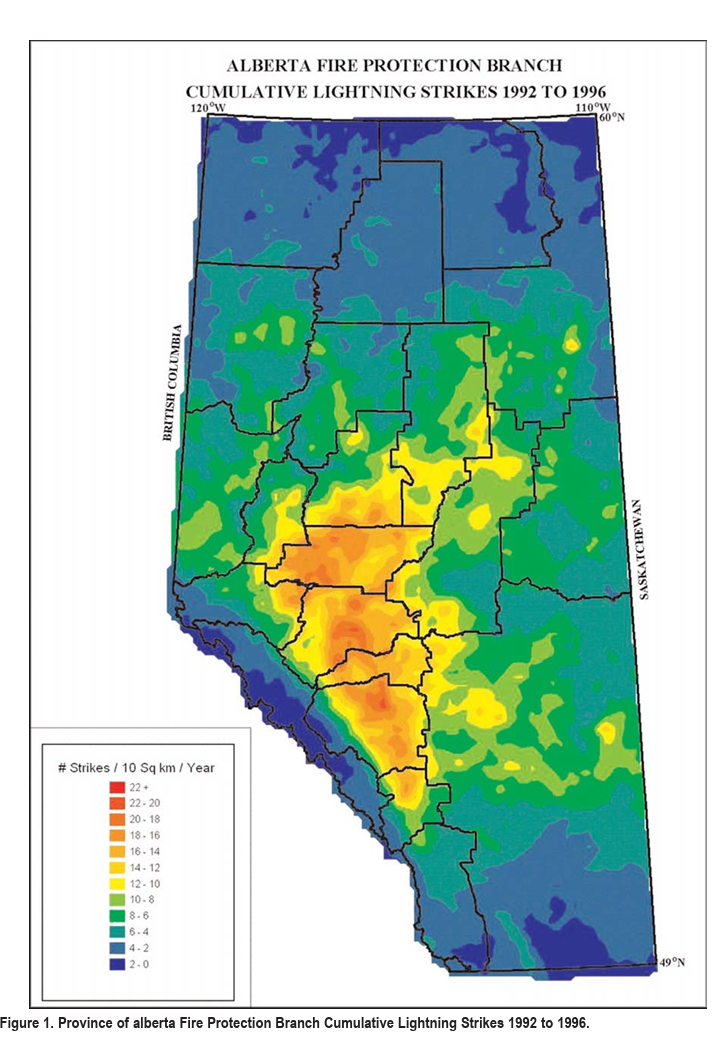

In [ ]:
from scipy.spatial import cKDTree

def get_lightning_data(merged_df, lightning_df):
    # rename columns to shorter names for easier access
    lightning_df = lightning_df.rename(columns={'Total cloud-to-ground lightning flashes from 1999-2018': 'lightning_count',
                                                'Average number of days with lightning (within 25 km)': 'avg_days_per_year'})

    # Step 1: KDTree on raw lat/lon
    lightning_coords = lightning_df[['Latitude', 'Longitude']].to_numpy()
    lightning_tree = cKDTree(lightning_coords)

    query_coords = merged_df[['LATITUDE', 'LONGITUDE']].to_numpy()

    # Step 2: Query k nearest cities
    k = 5
    dists, indices = lightning_tree.query(query_coords, k=k)

    # Step 3: Inverse distance squared weighting (avoid divide-by-zero)
    weights = 1 / np.clip(dists, 1e-6, None)**2  # 1/(distance)^2 weights

    # Step 4: Weighted average of lightning metrics
    lightning_counts = lightning_df['lightning_count'].str.replace(',', '').astype(float).values[indices]
    avg_days = lightning_df['avg_days_per_year'].astype(float).values[indices]

    weighted_counts = np.sum(lightning_counts * weights, axis=1) / np.sum(weights, axis=1)
    weighted_days = np.sum(avg_days * weights, axis=1) / np.sum(weights, axis=1)

    # Step 5: Add to DataFrame
    merged_df['lightning_count_index'] = weighted_counts
    merged_df['lightning_days_index'] = weighted_days
    return merged_df

In [ ]:
merged_df = pd.read_csv("./data_processing/OpenWeatherData/weather_fire_merged_4.csv")
lightning_df = pd.read_csv('./data_processing/LightningData/lightning_cities_data.csv')
merged_df = get_lightning_data(merged_df, lightning_df)
display(merged_df.head())
merged_df.to_csv("./data_processing/LightningData/weather_fire_lightning_merged_2024.csv", index=False)

,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE,temperature,pressure,humidity,wind_speed,wind_deg,weather,lightning_count_index,lightning_days_index
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True,290.48,1012,24,1.26,179,few clouds,28551.070256,34.203486
1,56.766883,-111.724250,2024-05-10 19:00:00,S1,True,299.39,1002,23,5.25,272,overcast clouds,22565.247370,33.029316
2,51.961340,-115.340712,2024-05-20 15:33:00,C1,True,275.59,1015,95,1.85,354,light rain,30035.933387,38.757269
3,58.712345,-111.188683,2024-05-23 16:00:00,M2,True,284.08,1016,49,2.26,68,overcast clouds,25007.666405,33.236686
4,55.645667,-116.067867,2024-05-24 11:10:00,O1a,True,283.02,1007,60,4.32,113,overcast clouds,28139.097721,34.906081


##### lightning data visualization
- Alberta Cities Lightning Data

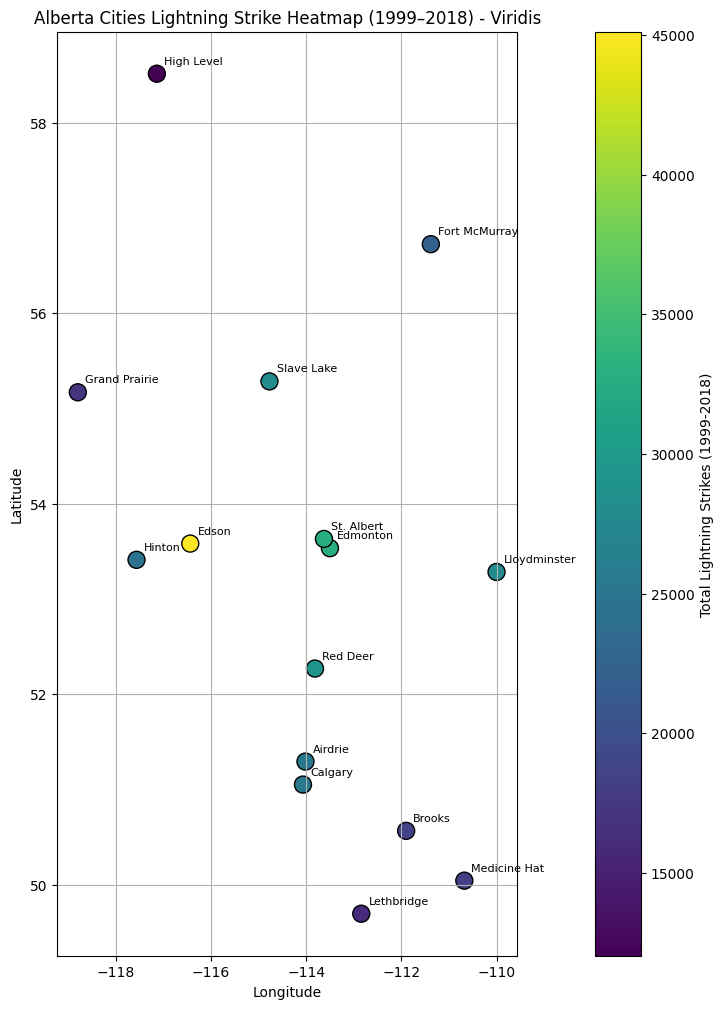

In [ ]:
import matplotlib.pyplot as plt

def plot_lightning_cities():
    # Load your CSV
    df = pd.read_csv('./data_processing/LightningData/lightning_cities_data.csv')

    # Clean up city names and lightning strike numbers
    df['City'] = df['City'].str.strip()
    df['Total_Strikes'] = df['Total cloud-to-ground lightning flashes from 1999-2018'].str.replace(",", "").astype(int)

    # Create scatter plot
    plt.figure(figsize=(20, 12))
    sc = plt.scatter(
        df['Longitude'],
        df['Latitude'],
        c=df['Total_Strikes'],
        cmap='viridis',
        s=150,
        edgecolors='black'
    )

    # Annotate each point with the city name
    for _, row in df.iterrows():
        plt.text(row['Longitude'] + 0.15, row['Latitude'] + 0.1, row['City'], fontsize=8)

    # Add colorbar and labels
    plt.colorbar(sc, label='Total Lightning Strikes (1999-2018)')
    plt.title('Alberta Cities Lightning Strike Heatmap (1999–2018) - Viridis')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    f = 1.0/np.cos(60*np.pi/180)
    plt.gca().set_aspect(f, adjustable='box')
    plt.grid(True)
    plt.show()
    
plot_lightning_cities()

- Computed lightning indices  
By plotting the lightning index, we see that the geodistribution of lightning index matches the cumulative lightning strikes distribution.

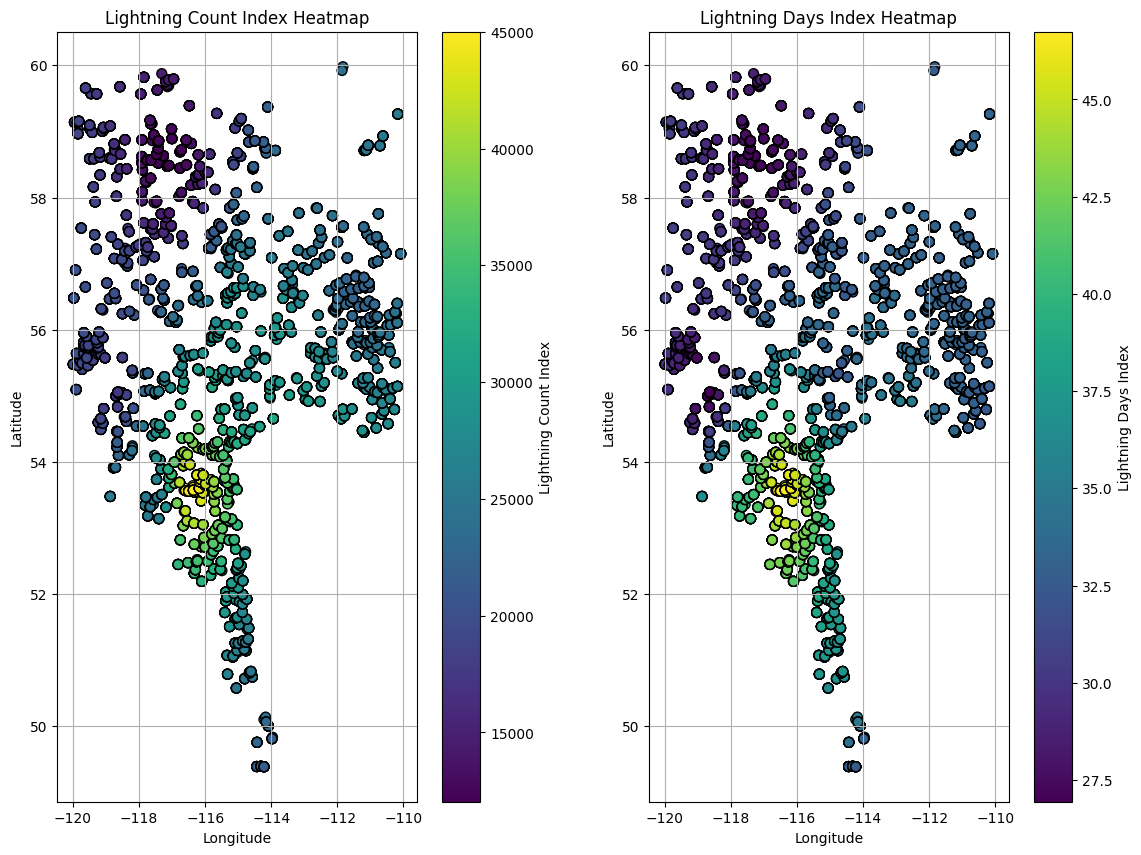

In [ ]:
def plot_computed_lightning_indices(merged_df):
    # plot merged_df['lightning_count_index'] as heat map for all longitude and latitude values
    fig, axes = plt.subplots(1, 2, figsize=(14, 10))

    # Plot lightning_count_index
    sc1 = axes[0].scatter(
        merged_df['LONGITUDE'], 
        merged_df['LATITUDE'], 
        c=merged_df['lightning_count_index'], 
        cmap='viridis', 
        s=50, 
        edgecolors='black'
    )
    axes[0].set_title('Lightning Count Index Heatmap')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    f = 1.0 / np.cos(60 * np.pi / 180)
    axes[0].set_aspect(f, adjustable='box')
    axes[0].grid(True)
    fig.colorbar(sc1, ax=axes[0], label='Lightning Count Index')

    # Plot lightning_days_index
    sc2 = axes[1].scatter(
        merged_df['LONGITUDE'], 
        merged_df['LATITUDE'], 
        c=merged_df['lightning_days_index'], 
        cmap='viridis', 
        s=50, 
        edgecolors='black'
    )
    axes[1].set_title('Lightning Days Index Heatmap')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    axes[1].set_aspect(f, adjustable='box')
    axes[1].grid(True)
    fig.colorbar(sc2, ax=axes[1], label='Lightning Days Index')

    plt.show()

plot_computed_lightning_indices(merged_df)

#### Population Density

The last dataset we obtained is the population density dataset. According to the Government of Alberta, 50% of total wildfires were human-caused in 2024, we noticed there’s a strong correlation between human activities and wildfires, and thus we believe population density of a place also plays an important role in creating wildfires. As a result, we obtained the population density of a total of 119 places in 2021, and we filtered out the following 3 specs: {population density per square kilometre, total private dwellings, geographic area type}. For any given location in the previous dataset, we find the 1 out of 119 places that is closest to the location and append its 3 features to that location.

In [ ]:
from scipy.spatial import cKDTree

cities_df = pd.read_csv("./data_processing/PopulationData/canadian_cities_with_coords.csv")
display(cities_df.head(1)) # 119 rows

def get_pop_density_data(merged_df):
    urban_coords = cities_df[['latitude', 'longitude']].to_numpy()
    urban_tree = cKDTree(urban_coords)

    # Compute nearest urban center
    def get_distance_to_urban(lat, lon):
        dist, idx = urban_tree.query([lat, lon], k=1)
        # also return the population density, dwelling count, and urban city type of the nearest urban center using its idx
        urban_density = cities_df.iloc[idx]['Population density per square kilometre, 2021']
        dwellings = cities_df.iloc[idx]['Total private dwellings, 2021']
        urban_type = cities_df.iloc[idx]['Geographic area type']
        # Geographic area types include 'Small population centre', 'Medium population centre', and 'Large urban population centre'
        # these labels are independent of the population density, for example the population density in Calgary (Large) is smaller than the population density in Airdrie (medium) and Chestermere (small)

        return dist*111, urban_type, urban_density, dwellings  # dist in degrees, multiply by ~111 km/deg for rough estimate

    # Apply to df
    merged_df[['dist_to_urban_km', 'urban_type', 'urban_population_density', 'urban_dwelling']] = pd.DataFrame(
        merged_df.apply(lambda row: get_distance_to_urban(row['LATITUDE'], row['LONGITUDE']), axis=1).tolist(),
        index=merged_df.index
    )

    return merged_df


,Geographic name,Geographic area type,Province or territory abbreviation,"Population, 2021","Population, 2016","Population percentage change, 2016 to 2021","Total private dwellings, 2021","Private dwellings occupied by usual residents, 2021","Land area in square kilometres, 2021","Population density per square kilometre, 2021",latitude,longitude
0,Airdrie,Medium population centre,Alta.,"73,578","61,082",20.5,"26,853","26,124",33.03,"2,227.30",51.28597,-114.01062


In [ ]:
merged_df = pd.read_csv("./data_processing/LightningData/weather_fire_lightning_merged_2024.csv")
merged_df = get_pop_density_data(merged_df)
display(merged_df.head(1))
merged_df.to_csv("./data_processing/Processed/wildfire_features_merged_2024.csv", index=False)

,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE,temperature,pressure,humidity,wind_speed,wind_deg,weather,lightning_count_index,lightning_days_index,dist_to_urban_km,urban_type,urban_population_density,urban_dwelling
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True,290.48,1012,24,1.26,179,few clouds,28551.070256,34.203486,66.853982,Small population centre,726.2,991


### Data Preprocessing
Our data preprocessing steps standardize these differently structured data, unifying feature extraction in both spatial and temporal dimensions to provide consistent support for model training.

## Methodology
<font color='red'>You should focus less on introducing the algorithms and more introducing your problem, data and how/why you use certain algorithms. </font>

### 1. Logistic Regression

This project chose to use Logistic Regression because of its effectiveness in binary classification tasks. In the project, the model will distinguish between fire and non-fire conditions based on environmental features such as temperature, humidity, wind speed, and weather conditions.
Logistic regression is suitable for predicting wildfires because it is interpretable, efficient and predictive. The first advantage is the ability to analyze how each feature affects the probability of a wildfire occurring through the learned data. This interpretability helps understand which environmental factors have the greatest impact on fire risk. In addition, logistic regression is computationally efficient, which allows it to handle datasets of various specifications. A final advantage is its ability to generate estimated probabilities, not just binary classifications, which will visualize the results. In the end, logistic regression is less prone to overfitting than more complex models. This allows the model to make relatively accurate predictions not only on training sets, but also on real-world data.
The implementation of the logistic regression model followed a structured set of methods that would ensure its effectiveness in predicting wildfire. First, wildfire occurrence data is collected and preprocessed to ensure the dataset includes essential environmental factors for accurate fire risk assessment. After data preparation, the dataset is divided into an 80% training set and a 20% test set. This division of the data allows the model to learn from the majority of the data, while keeping a separate test set for evaluating the model's performance. ​
After data preparation, model training was started. The logistic regression model was initialized and the maximum number of iterations was set to 1000 to ensure proper convergence during optimization. The model was then trained using the training dataset to allow it to learn the relationship between input environmental factors and wildfire occurrence. Once training was completed, multiple evaluation metrics were used to measure the effectiveness of the model.
####  How to Evaluation
The construction of the logistic regression model forms a solid benchmark for wildfire prediction. Although the model is highly interpretable and computationally efficient, it still has limitations in capturing complex nonlinear relationships in the dataset. Therefore, future research will explore more advanced models, such as Decision Trees and Neural Networks, to further improve prediction accuracy and enhance the effectiveness of wildfire prevention strategies.


## Model Training

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
from sklearn.metrics import root_mean_squared_error

### C.0 Input Feature and Target Ground Truth Processing

Training and Testing datasets are divided using `K-Fold Cross Evaluation` with `K=5` to partition the data corresponding to the 80-20 rule.
- Training Dataset contains all data of the other 4-Folds
- Testing Dataset is the current Fold's data.

Final Processings are needed to extract `features` and `output labels` from the aggregated datasets to ensure generalizable models on un-seen data:
1. All ID related fields are dropped from the dataframe, including station identifier, Fire Date, latitude, longtitude
2. Fire Columm, which is the ground truth of training and testing data, are dropped from othe feature dataframe to form X, input dataset.
3. Label Dataframe, or Ground Truth Dataframe is composed of binary classfication label, `Fire` alone, forming y, target datset.
4. StratifiedKFold loads the global feature and target dataset that gaurantees similar distribution of True and False classification samples in each Fold. 

Note this results in a X: Feature Dataframe y: Ground Truth Dataframe, and skf: K-cross evaluation splitting nodule, that generates K folds of X, y data for training and testing. The X, y, skf can be used for all models below, including Linear Regression, Decision Tree. and Fully Connected Neural Network model.

In this project, the available features were initially:  
`['LATITUDE', 'LONGITUDE', 'START_DATE', 'FUEL_TYPE', 'FIRE', 'Date', 'Spd of Max Gust (km/h)', 'Total Precip (mm)', 'Mean Temp (°C)', 'Min Temp (°C)', 'Max Temp (°C)', 'Distance to Weather Station (km)', 'dist_to_urban_deg', 'urban_type', 'urban_population_density', 'urban_dwelling', 'dist_to_urban_km']`

However, after preprocessing, identification fields and non-relevant fields (`LATITUDE`, `LONGITUDE`, `START_DATE`, `Date`) were removed. The final model input features are:

- `Spd of Max Gust (km/h)`
- `Total Precip (mm)`
- `Mean Temp (°C)`
- `Min Temp (°C)`
- `Max Temp (°C)`
- `Distance to Weather Station (km)`
- `dist_to_urban_deg`
- `urban_type` (one-hot encoded categorical variable)
- `urban_population_density`
- `urban_dwelling`
- `dist_to_urban_km`
- `FUEL_TYPE` (one-hot encoded categorical variable)

These selected features directly represent environmental conditions and urban-related risk factors contributing to wildfire risk.

In [ ]:
FILE = "/mnt/d/446Project/WeatherTransformer/data_processing/Processed/generated_population_infused_large_2007_2024.csv"
KFOLD = 5

def load_training_data(file = FILE):
    
    # Load aggregated datasets and drop senstive ID-indicating colunms
    df_og = pd.read_csv(file)
    df = df_og.loc[:, ~df_og.columns.str.contains("latitude|longitude|date|tude", case=False)].copy()
    df["FIRE"] = df["FIRE"].astype(float)
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = df[col].str.replace(",", "").astype(float)
            except:
                # print("exception: likely categorical, leave it for one-hot encoding")
                pass

    # Separate features and labels from aggreagated datasets
    label = df["FIRE"].values.astype(np.float32)
    features = df.drop(columns=["FIRE"])

    print("\n Features used for training:")
    print(features.columns.tolist())
    print(f"\n Target to predict: 'FIRE'\n")

    label_counts = df["FIRE"].value_counts().sort_index()
    total = label_counts.sum()
    print("\nFire Occurrence Statistics:")
    for label_i, count in label_counts.items():
        percent = (count / total) * 100
        print(f"Class {int(label_i)}: {count} instances ({percent:.2f}%)")

    # One-hot encode remaining categorical columns (if any)
    features = pd.get_dummies(features)

    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    X = torch.tensor(features_scaled, dtype=torch.float32)
    y = torch.tensor(label, dtype=torch.float32)

    # K-fold Cross-validation of the entire dataset are prepared for any modle usage
    skf = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=42)

    return X, y, skf, df_og


def plot_fire_distribution_by_location(df, skf, lat_col='LATITUDE', lon_col='LONGITUDE', label_col='FIRE'):
    """
    Plot fire vs non-fire points by latitude and longitude, colored by fold ID.
    """
    assert lat_col in df.columns and lon_col in df.columns and label_col in df.columns, "Missing required columns."

    # Prepare inputs
    X = df.drop(columns=[label_col])
    y = df[label_col].astype(int).values
    coordinates = df[[lat_col, lon_col]].values

    # Assign a fold ID to each row
    fold_ids = np.zeros(len(df), dtype=int)
    for fold, (_, test_idx) in enumerate(skf.split(X, y)):
        fold_ids[test_idx] = fold

    df['FOLD'] = fold_ids
    df['FIRE'] = y

    # Plot
    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('tab10')

    for fold in range(skf.n_splits):
        fold_df = df[df['FOLD'] == fold]

        # Non-fire
        no_fire = fold_df[fold_df[label_col] == 0]
        plt.scatter(no_fire[lon_col], no_fire[lat_col],
                    color=cmap(fold),
                    label=f'Fold {fold+1} - No Fire',
                    alpha=0.6,
                    marker='o',
                    edgecolors='k',
                    linewidths=0.5,
                    s=30)

        # Fire
        fire = fold_df[fold_df[label_col] == 1]
        plt.scatter(fire[lon_col], fire[lat_col],
                    color=cmap(fold),
                    label=f'Fold {fold+1} - Fire',
                    alpha=0.8,
                    marker='x',
                    linewidths=1.5,
                    s=50)

    plt.title("Wildfire Distribution by Location and Fold")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend(loc='best', fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()


X, y, skf, df = load_training_data()
print(y)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plot_fire_distribution_by_location(df, skf)

### 3. Fully Connected Neural Network (FCNN)




## Results & Analysis

## Conclusion & Future Work

## References

[1] A. School, “Economic Impact of the Los Angeles Wildfires,” UCLA Anderson School of Management, Jan. 31, 2025. https://www.anderson.ucla.edu/about/centers/ucla-anderson-forecast/economic-impact-los-angeles-wildfires

[2] Government of Alberta, “2023 Alberta Wildfire’s seasonal statistics,” Dec. 2023.

[3] Sanabria L.A., Qin X., Li J., Cechet R.P., and Lucas C. 2013. Spatial interpolation of McArthur’s Forest Fire Danger Index across Australia: observational study. Environ. Model. Softw. 50: 37–50.

[4] Shadrin, D., Illarionova, S., Gubanov, F. et al. Wildfire spreading prediction using multimodal data and deep neural network approach. Sci Rep 14, 2606 (2024). https://doi.org/10.1038/s41598-024-52821-x

[5] G. Bayat and K. Yıldız, “Comparison of the Machine Learning Methods to Predict Wildfire Areas”, TJST, vol. 17, no. 2, pp. 241–250, 2022, doi: 10.55525/tjst.1063284.

[6] N. R. Canada, “Fire weather maps,” Canadian Wildland Fire Information System, https://cwfis.cfs.nrcan.gc.ca/maps/fw?type=fwi (accessed Apr. 4, 2025). 

[7] “Historical wildfire data : 2006 to 2023 - Open Government,” Alberta.ca, 2023. https://open.alberta.ca/opendata/wildfire-data

[8] N. R. Canada, “Canadian Wildland Fire Information System | Background Maps,” Nrcan.gc.ca, 2025. https://cwfis.cfs.nrcan.gc.ca/background/maps/fbpft (accessed Apr. 04, 2025).